In [1]:
from xenonnt_plot_style import XENONPlotStyle as xps
xps.use('xenonnt')

import numpy as np
import appletree as apt
import aptext
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps

from tqdm import tqdm
from GOFevaluation import BinnedPoissonChi2GOF, ADTestTwoSampleGOF

XLA_PYTHON_CLIENT_PREALLOCATE is set to false
XLA_PYTHON_CLIENT_ALLOCATOR is set to platform
Using aptext package from https://github.com/XENONnT/applefiles


In [4]:
apt.clear_cache()
filename = '/home/ykaminaga/appletree/sr1_rn220_fitting.h5'
context = apt.Context.from_backend(filename)
component = context.likelihoods['rn220_llh'].components['rn220_er']

OSError: [Errno 5] Input/output error

In [4]:
print(component.code)

from functools import partial
from jax import jit
from appletree.plugins import PositionSpectra
from appletree.plugins import UniformEnergySpectra
from appletree.plugins import RecombFluct
from appletree.plugins import mTI
from appletree.plugins import Quanta
from appletree.plugins import TrueRecombER
from appletree.plugins import IonizationER
from appletree.plugins import DriftLoss
from appletree.plugins import RecombinationER
from appletree.plugins import S2LCE
from appletree.plugins import ElectronDrifted
from appletree.plugins import S2PE
from appletree.plugins import S1LCE
from appletree.plugins import PhotonDetection
from appletree.plugins import S1PE
from appletree.plugins import S2
from appletree.plugins import S1
from appletree.plugins import S1NHits
from appletree.plugins import PositionRecon
from appletree.plugins import AntiCorrelationEfficiency
from appletree.plugins import FiducialVolumeCylinderAccept
from appletree.plugins import S2CutAccept
from appletree.plugins import

In [5]:
context.config

{'elife': 'elife_bkg_sr1.json',
 'event_building_eff': 'anti_correlation_eff_rn220_sr1.json',
 'posrec_reso': 'posrec_reso_sr0.json',
 's1_bias_3f': '3fold_s1_bias_rn220_sr1.json',
 's1_correction': 's1_correction_sr1.json',
 's1_cut_acc': ['s1_cut_acc_median_rn220_sr1.json',
  's1_cut_acc_lower_rn220_sr1.json',
  's1_cut_acc_upper_rn220_sr1.json'],
 's1_eff_n_hits_3f': ['3fold_recon_eff_n_hits_median_sr0.json',
  '3fold_recon_eff_n_hits_lower_sr0.json',
  '3fold_recon_eff_n_hits_upper_sr0.json'],
 's1_lce': 's1_correction_sr1.json',
 's1_smear_3f': '3fold_s1_smearing_rn220_sr1.json',
 's2_bias': 's2_bias_rn220_sr1.json',
 's2_correction': 's2_correction_sr1.json',
 's2_cut_acc': ['s2_cut_acc_median_rn220_sr1.json',
  's2_cut_acc_lower_rn220_sr1.json',
  's2_cut_acc_upper_rn220_sr1.json'],
 's2_lce': 's2_correction_sr1.json',
 's2_smear': 's2_smearing_rn220_sr1.json'}

In [6]:
from appletree.share import _cached_configs, _cached_functions
_cached_configs

{
    "anti_correlation_eff": "/home/ykaminaga/appletree/applefiles/files/fake_maps/_anti_correlation_eff.json",
    "elife": "/home/ykaminaga/appletree/applefiles/files/electron_lifetime/elife_bkg_sr1.json",
    "event_building_eff": "/home/ykaminaga/appletree/applefiles/files/rn220_ambience/anti_correlation_eff_rn220_sr1.json",
    "gas_gain_relative": "/home/ykaminaga/.local/lib/python3.11/site-packages/appletree/maps/_gas_gain_relative.json",
    "lower_energy": 0.01,
    "posrec_reso": "/home/ykaminaga/appletree/applefiles/files/posrec/posrec_reso_sr0.json",
    "r_max": 60.0,
    "s1_bias_3f": "/home/ykaminaga/appletree/applefiles/files/s1_bias/3fold_s1_bias_rn220_sr1.json",
    "s1_correction": "/home/ykaminaga/appletree/applefiles/files/s1_xyz/s1_correction_sr1.json",
    "s1_cut_acc": [
        "s1_cut_acc_median_rn220_sr1.json",
        "s1_cut_acc_lower_rn220_sr1.json",
        "s1_cut_acc_upper_rn220_sr1.json"
    ],
    "s1_cut_acc_lower": {
        "rn220_llh": "s1_cut_ac

In [ ]:
# parameters = context.get_post_parameters()
# key = apt.get_key()
# key, (cs1, cs2, eff) = component.simulate(key, int(2e6), parameters)
# mask = cs1 <= 100
# mask &= cs1 >= 0
# mask &= cs2 <= 1e4
# mask &= cs2 >= 1e2
# mask &= np.random.rand(len(cs1)) < eff

# reference_sample = np.array([cs1[mask], cs2[mask]]).T

# ac_sample = pd.read_csv('/home/zihaoxu/private_nt_aux_files/apt_files/ac_template_rn220_sr1.csv')
# ac_rate = int(parameters['rn220_ac_rate'] / parameters['rn220_er_rate'] * len(reference_sample))
# index = np.random.choice(len(ac_sample), size=ac_rate)
# ac_sample = ac_sample[['cs1', 'cs2']].to_numpy()[index]

# reference_sample = np.concatenate([reference_sample, ac_sample])

# pd.DataFrame({
#     'cs1': reference_sample[:, 0],
#     'cs2': reference_sample[:, 1],}).to_pickle('./toymc_rn220.pkl')

df = pd.read_pickle('toymc_rn220.pkl')
reference_sample = df.to_numpy()

data_sample = pd.read_csv(apt.get_file_path('data_rn220_sr1.csv'))[['cs1', 'cs2']].to_numpy()
mask = data_sample[:, 0] <= 100
mask &= data_sample[:, 0] >= 0
mask &= data_sample[:, 1] <= 1e4
mask &= data_sample[:, 1] >= 1e2
data_sample = data_sample[mask]

In [ ]:
gof = BinnedPoissonChi2GOF.bin_equiprobable(
    data_sample,
    reference_sample,
    len(data_sample),
    [10, 9],
    plot=True,
    vmin=-3,
    vmax=+3,
)
plt.scatter(data_sample[:, 0],
            data_sample[:, 1],
            s=0.1, color='k')

plt.title(f"p = {gof.get_pvalue():.2f}")
plt.yscale('log')
plt.xlabel('cS1 [PE]')
plt.ylabel('cS2 [PE]')
# plt.savefig("./fig/gof.png")
plt.show()

In [ ]:
plotter = apt.Plotter('/home/zihaoxu/sr1_rn220_fitting.h5', discard=0)
plotter.plot_burn_in()
plt.savefig('./fig/burn_in.png')

In [ ]:
plotter = apt.Plotter('/home/zihaoxu/sr1_rn220_fitting.h5', discard=10000)
plotter.plot_marginal_posterior()
plt.savefig('./fig/marginal.png')

In [ ]:
import emcee
import copy
import multihist as mh

class YieldModel():
    def __init__(self, context, discard=0):
        self.logp = context.sampler.get_log_prob(flat=True, discard=discard)
        self.chain = context.sampler.get_chain(flat=True, discard=discard)
    
    def yields(self, energy, w, nex_ni_ratio, py0, py1, py2, py3, py4, field, **kwargs):
        ni = energy / w * 1 / (1 + nex_ni_ratio)
        zeta = 1 / 4 * py0 * np.exp(-energy / py1) * field ** py2
        recomb = 1 / (1 + np.exp(-(energy - py3) / py4)) * (1 - np.log(1 + ni * zeta) / ni / zeta)
        qy = ni * (1 - recomb) / energy
        ly = 1 / w - qy
        return ly, qy
    
    def get_parameters(self):
        """Get parameters correspondes to max posterior."""
        ind = np.random.randint(len(self.logp))
        _parameters = self.chain[ind]
        _parameters = emcee.ensemble.ndarray_to_list_of_dicts(
            np.atleast_2d(_parameters),
            context.sampler.parameter_names,
        )[0]
        parameters = copy.deepcopy(context.par_manager.get_all_parameter())
        parameters.update(_parameters)
        return parameters
    
    def __call__(self, energy, size=0):
        E, Ly, Qy = [], [], []
        for _ in range(size):
            ly, qy = self.yields(energy, **self.get_parameters())
            E.append(energy)
            Ly.append(ly)
            Qy.append(qy)
        E = np.concatenate(E)
        Ly = np.concatenate(Ly)
        Qy = np.concatenate(Qy)
        return E, Ly, Qy

In [ ]:
y = YieldModel(context, discard=5000)
energy, ly, qy = y(np.geomspace(0.05, 31, 100), size=10000)
df = pd.DataFrame({'energy': energy, 'ly': ly, 'qy': qy})

yields = df.groupby('energy').agg(
    ly_median=pd.NamedAgg(column="ly", aggfunc=lambda x: np.percentile(x, sps.norm.cdf(0) * 100)),
    ly_lower=pd.NamedAgg(column="ly", aggfunc=lambda x: np.percentile(x, sps.norm.cdf(-1) * 100)),
    ly_upper=pd.NamedAgg(column="ly", aggfunc=lambda x: np.percentile(x, sps.norm.cdf(1) * 100)),
    qy_median=pd.NamedAgg(column="qy", aggfunc=lambda x: np.percentile(x, sps.norm.cdf(0) * 100)),
    qy_lower=pd.NamedAgg(column="qy", aggfunc=lambda x: np.percentile(x, sps.norm.cdf(-1) * 100)),
    qy_upper=pd.NamedAgg(column="qy", aggfunc=lambda x: np.percentile(x, sps.norm.cdf(1) * 100)),
)

# G1 = {'sr0': 0.1515, 'sr1': 0.1367, 'sr1a': 0.1367, 'sr1b': 0.1367}
# G2 = {'sr0': 16.45, 'sr1': 16.85, 'sr1a': 16.85, 'sr1b': 16.85}

Text(0, 0.5, 'Photon yield [ph/keV]')

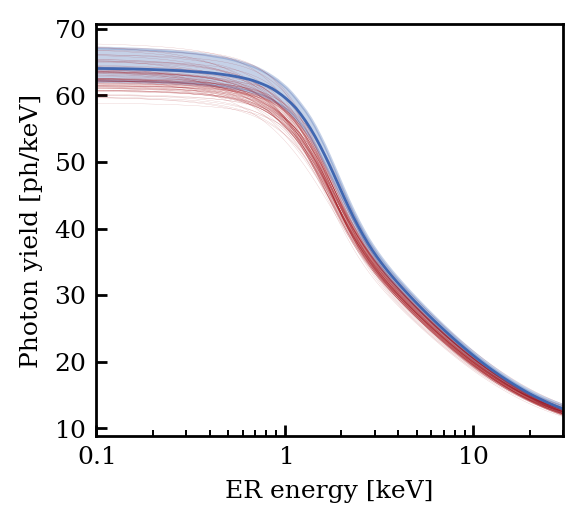

In [19]:
import json
with open('/home/zihaoxu/Paper_Plots/SR0_Analysis_Paper_II/bbf_emission_model/data_er/er_emission_model.json', 'r') as file:
    data = json.load(file)

plt.figure(figsize=(2.8, 2.5))

for i in range(100):
    df_slice = df.iloc[i * 100:i * 100 + 100]
    plt.plot(df_slice['energy'], df_slice['qy'], color=xps.colors['darkred'], lw=0.1, alpha=0.3)


l1, = plt.plot(data['energy'], data['Qy']['median'], color=xps.colors['xenon_blue'])
b1 = plt.fill_between(data['energy'], data['Qy']['lower'], data['Qy']['upper'], color=xps.colors['xenon_blue'], alpha=0.3)

plt.xscale('log')
plt.xlim(0.1, 30)
plt.xlabel('ER energy [keV]')
plt.ylabel('Photon yield [ph/keV]')

In [ ]:
import json
with open('/home/zihaoxu/Paper_Plots/SR0_Analysis_Paper_II/bbf_emission_model/data_er/er_emission_model.json', 'r') as file:
    data = json.load(file)

plt.figure(figsize=(2.8, 2.5))
l1, = plt.plot(data['energy'], data['Ly']['median'], color=xps.colors['xenon_blue'])
b1 = plt.fill_between(data['energy'], data['Ly']['lower'], data['Ly']['upper'], color=xps.colors['xenon_blue'], alpha=0.3)
l2, = plt.plot(yields.index, yields['ly_median'], color=xps.colors['darkred'])
b2 = plt.fill_between(yields.index, yields['ly_lower'], yields['ly_upper'], color=xps.colors['darkred'], alpha=0.3)

plt.legend([(l1, b1), (l2, b2)],
           [r'SR0 ${}^{220}$Rn+${}^{37}$Ar', r'SR1 ${}^{220}$Rn'])
plt.xscale('log')
plt.xlim(0.1, 30)
plt.xlabel('ER energy [keV]')
plt.ylabel('Photon yield [ph/keV]')
# plt.ylabel('g1 x Photon yield [PE/keV]')
# plt.savefig('./fig/ly.png')
plt.show()

In [ ]:
import json
with open('/home/zihaoxu/Paper_Plots/SR0_Analysis_Paper_II/bbf_emission_model/data_er/er_emission_model.json', 'r') as file:
    data = json.load(file)

plt.figure(figsize=(2.8, 2.5))
l1, = plt.plot(data['energy'], data['Qy']['median'], color=xps.colors['xenon_blue'])
b1 = plt.fill_between(data['energy'], data['Qy']['lower'], data['Qy']['upper'], color=xps.colors['xenon_blue'], alpha=0.3)
l2, = plt.plot(yields.index, yields['qy_median'], color=xps.colors['darkred'])
b2 = plt.fill_between(yields.index, yields['qy_lower'], yields['qy_upper'], color=xps.colors['darkred'], alpha=0.3)

plt.legend([(l1, b1), (l2, b2)],
           [r'SR0 ${}^{220}$Rn+${}^{37}$Ar', r'SR1 ${}^{220}$Rn'])
plt.xscale('log')
plt.xlim(0.1, 30)
plt.xlabel('ER energy [keV]')
# plt.ylabel('g2 x Charge yield [PE/keV]')
plt.ylabel('Charge yield [e$^-$/keV]')
# plt.savefig('./fig/qy.png')
plt.show()

In [ ]:
from matplotlib import colors

# Define cmap
original_cmap = plt.cm.PiYG
colors_list = original_cmap(np.clip(np.linspace(0, 1, 256)**0.3, 0, 0.6))
colors_list = np.clip(colors_list, 0, 1)
cmap = colors.ListedColormap(colors_list)

def slice_mask(x, lower, upper):
    return (x >= lower) & (x < upper)

p_values = []
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = np.ravel(axes)

for i, ax in tqdm(enumerate(axes)):
    lower = i * 10
    upper = lower + 10

    mask = slice_mask(reference_sample[:, 0], lower, upper)
    cs2_ref = reference_sample[mask][:, 1]
    ax.plot(np.sort(cs2_ref), np.linspace(0, 1, len(cs2_ref)), color=xps.colors['xenon_blue'], label=r'SR1 best-fit ER model')

    mask = slice_mask(data_sample[:, 0], lower, upper)
    cs2_data = data_sample[mask][:, 1]
    ax.plot(np.sort(cs2_data), np.linspace(0, 1, len(cs2_data)), color=xps.colors['darkred'], label=r'SR1 $^{220}$Rn data')

    downsample_mask = np.random.choice([True, False], size=len(cs2_ref), p=[0.05, 0.95])
    gof = ADTestTwoSampleGOF(cs2_data, cs2_ref[downsample_mask])
    p = gof.get_pvalue(1000)
    # p = 0.1
    p_values.append(p)
    ax.set_facecolor(cmap(p))

    ax.axhline(1, color='k', ls='--')
    ax.set_title(fr'{lower} < cS1 / PE < {upper}', fontsize=9)

    ax.set_xscale('log')
    ax.set_xlim(5e2, 1e4)
    ax.set_ylim(0, 1.1)
    ax.set_yticks([0, 0.5, 1])
    if not i % 5:
        ax.set_ylabel('CDF')
    if i < 5:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('cS2 [PE]')

handles, labels = ax.get_legend_handles_labels()
fig.legend(loc="lower center", handles=handles, labels=labels, bbox_to_anchor=(0.5, 1.0))

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, label='Anderson–Darling test p-value', ax=axes.ravel().tolist(), pad=0.03, aspect=50)

plt.savefig('./fig/cs1_slice_ad_test.png', bbox_inches='tight')
# plt.savefig('./fig/cs1_slice_ad_test.svg', bbox_inches='tight')
plt.show()

In [ ]:
p_values = np.array(p_values)
plt.errorbar(np.arange(5, 105, 10), p_values, yerr=np.sqrt(p_values * (1-p_values) / 1000), xerr=5, ls='', capsize=0)
plt.axhline(1, ls='--', color='k')
plt.xlim(0, 100)
plt.ylim(5e-2, 2)
# plt.ylim(0, 1.1)
plt.yscale('log')
plt.xlabel('cS1 [PE]')
plt.ylabel('Anderson–Darling test p-value')
plt.savefig('./fig/cs1_slice_ad_test_p_value.png')
# plt.savefig('./fig/cs1_slice_ad_test_p_value.svg')
plt.show()